## **Project: Prediction of Acute Aquatic Toxicity Toward Daphnia Magna**
- **Source**: Cassotti et al. (2014), Prediction of Acute Aquatic Toxicity 
Toward Daphnia magna by using the GA-kNN Method, Alternatives to Laboratory 
Animals Volume 42, Issue 1, March 2014
- **URL**: https://journals.sagepub.com/doi/epdf/10.1177/026119291404200106
- **Date**: 05/12/24
- **Goal**: Create a basic prediction model and a feature explainer

In [4]:
import pickle
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,  
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    r2_score,
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error
)
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

#### **1. Data Loading**

In [6]:
df_raw = pd.read_csv("../data/raw/qsar_aquatic_toxicity.csv", sep=";", header=None)
df_raw.columns = ['TPSA','SAcc','H050','MLOGP','RDCH','GATS1p','nN','C040','LC50']
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TPSA    546 non-null    float64
 1   SAcc    546 non-null    float64
 2   H050    546 non-null    int64  
 3   MLOGP   546 non-null    float64
 4   RDCH    546 non-null    float64
 5   GATS1p  546 non-null    float64
 6   nN      546 non-null    int64  
 7   C040    546 non-null    int64  
 8   LC50    546 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 38.5 KB


In [7]:
df_raw.sample(10, random_state=2025)

,TPSA,SAcc,H050,MLOGP,RDCH,GATS1p,nN,C040,LC50
240,0.00,0.000,0,6.232,2.728,0.493,0,0,7.610
57,87.66,139.995,3,1.589,3.514,1.339,2,1,3.819
143,83.67,84.184,1,0.349,2.397,2.092,1,1,5.760
493,0.00,0.000,0,3.259,1.979,1.111,0,0,4.300
48,29.10,43.156,1,3.076,2.438,0.773,1,1,4.714
400,111.87,144.177,1,1.748,2.377,0.839,2,0,4.790
424,13.14,9.507,0,3.743,2.995,0.783,0,0,4.737
381,20.23,42.683,1,2.637,2.344,0.758,0,0,4.610
482,110.45,141.047,1,2.767,3.488,1.216,2,2,4.071
475,44.45,16.786,0,1.157,1.334,0.685,1,1,5.418


#### **2. Data preprocessing**

In [8]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tpsa    546 non-null    float64
 1   sacc    546 non-null    float64
 2   h050    546 non-null    int64  
 3   mlogp   546 non-null    float64
 4   rdch    546 non-null    float64
 5   gats1p  546 non-null    float64
 6   nn      546 non-null    int64  
 7   c040    546 non-null    int64  
 8   lc50    546 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 38.5 KB


#### **3. EDA**

In [10]:
df_train, df_test = train_test_split(
    df, 
    test_size=0.15, 
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train,
    test_size=0.15,
    random_state=2025
)
df_train.reset_index(drop=True,inplace=True)
df_val.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tpsa    394 non-null    float64
 1   sacc    394 non-null    float64
 2   h050    394 non-null    int64  
 3   mlogp   394 non-null    float64
 4   rdch    394 non-null    float64
 5   gats1p  394 non-null    float64
 6   nn      394 non-null    int64  
 7   c040    394 non-null    int64  
 8   lc50    394 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 27.8 KB


In [11]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
tpsa,394.0,47.948782,44.560692,0.000,15.79000,39.830,70.14000,278.800
sacc,394.0,58.606421,63.801197,0.000,11.00000,43.290,78.20400,413.191
h050,394.0,0.934010,1.379866,0.000,0.00000,0.000,1.00000,8.000
mlogp,394.0,2.295548,1.669830,-1.960,1.20475,2.248,3.34875,6.728
rdch,394.0,2.481614,0.788144,1.000,1.97500,2.334,2.90300,6.439
gats1p,394.0,1.043487,0.400301,0.281,0.73850,1.028,1.24600,2.500
nn,394.0,1.012690,1.429369,0.000,0.00000,0.000,2.00000,11.000
c040,394.0,0.347716,0.849132,0.000,0.00000,0.000,0.00000,11.000
lc50,394.0,4.635990,1.621199,0.122,3.60600,4.463,5.56150,10.047


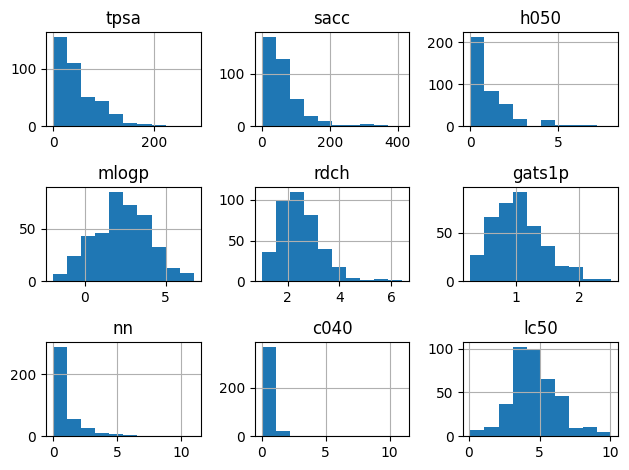

In [15]:
df_train.hist()
plt.tight_layout()
plt.show()

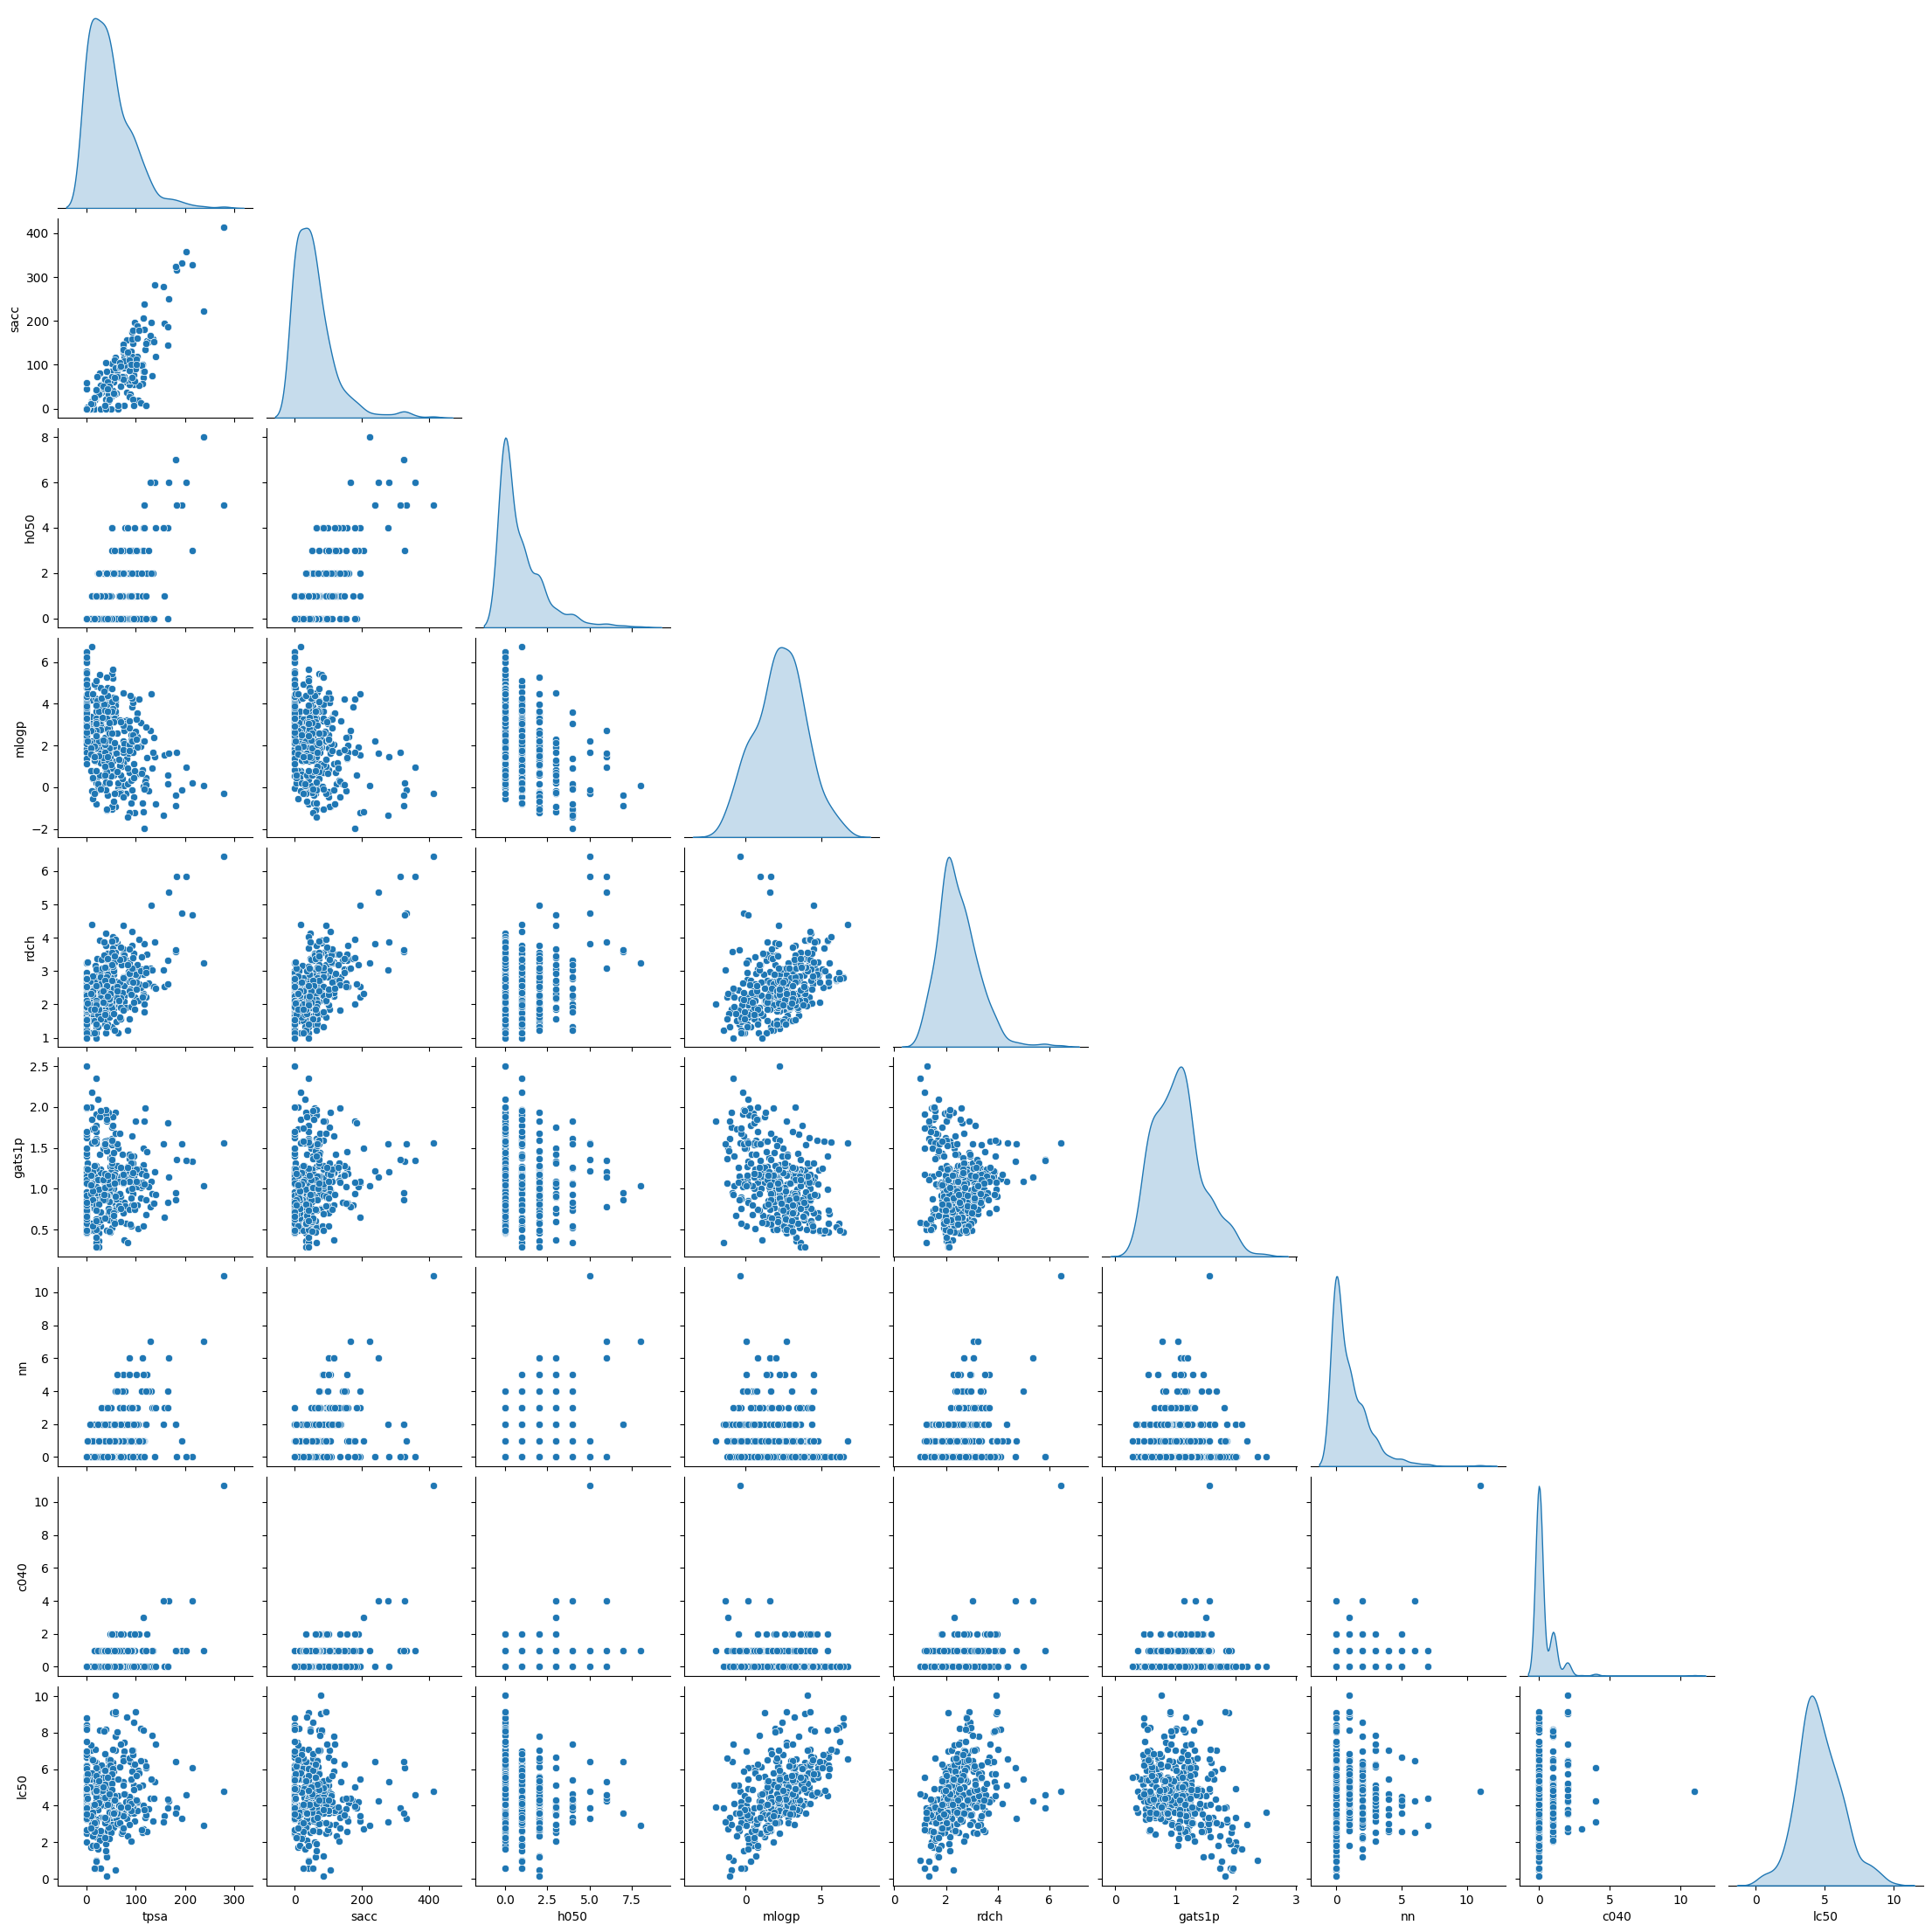

In [16]:
sns.pairplot(df_train, diag_kind="kde", corner=True)
plt.show()

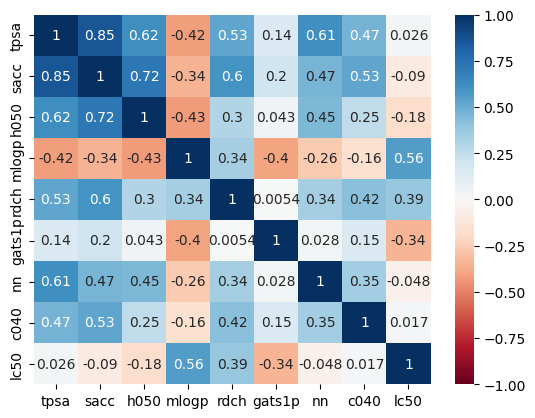

In [19]:
sns.heatmap(data=df_train.corr(), vmin=-1, vmax=1, cmap="RdBu",annot=True)
plt.show()

#### **4. Machine Learning**